<a href="https://colab.research.google.com/github/flrain2/test/blob/main/GaussianNB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 가우시안 나이브베이즈 모형



#### GaussianNB code: https://github.com/scikit-learn/scikit-learn/blob/95119c13a/sklearn/naive_bayes.py#L118
sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html

In [ ]:
class GaussianNB(_BaseNB):
    """
    Gaussian Naive Bayes (GaussianNB)
    Can perform online updates to model parameters via :meth:`partial_fit`.
    For details on algorithm used to update feature means and variance online,
    see Stanford CS tech report STAN-CS-79-773 by Chan, Golub, and LeVeque:
        http://i.stanford.edu/pub/cstr/reports/cs/tr/79/773/CS-TR-79-773.pdf
    Read more in the :ref:`User Guide <gaussian_naive_bayes>`.
    Parameters
    ----------
    priors : array-like of shape (n_classes,)
        Prior probabilities of the classes. If specified the priors are not
        adjusted according to the data.
    var_smoothing : float, default=1e-9
        Portion of the largest variance of all features that is added to
        variances for calculation stability.
        .. versionadded:: 0.20
    Attributes
    ----------
    class_count_ : ndarray of shape (n_classes,)
        number of training samples observed in each class.
    class_prior_ : ndarray of shape (n_classes,)
        probability of each class.
    classes_ : ndarray of shape (n_classes,)
        class labels known to the classifier
    epsilon_ : float
        absolute additive value to variances
    sigma_ : ndarray of shape (n_classes, n_features)
        variance of each feature per class
    theta_ : ndarray of shape (n_classes, n_features)
        mean of each feature per class
    Examples
    --------
    >>> import numpy as np
    >>> X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
    >>> Y = np.array([1, 1, 1, 2, 2, 2])
    >>> from sklearn.naive_bayes import GaussianNB
    >>> clf = GaussianNB()
    >>> clf.fit(X, Y)
    GaussianNB()
    >>> print(clf.predict([[-0.8, -1]]))
    [1]
    >>> clf_pf = GaussianNB()
    >>> clf_pf.partial_fit(X, Y, np.unique(Y))
    GaussianNB()
    >>> print(clf_pf.predict([[-0.8, -1]]))
    [1]
    """

    @_deprecate_positional_args
    def __init__(self, *, priors=None, var_smoothing=1e-9):
        self.priors = priors
        self.var_smoothing = var_smoothing

    def fit(self, X, y, sample_weight=None):
        """Fit Gaussian Naive Bayes according to X, y
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training vectors, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape (n_samples,)
            Target values.
        sample_weight : array-like of shape (n_samples,), default=None
            Weights applied to individual samples (1. for unweighted).
            .. versionadded:: 0.17
               Gaussian Naive Bayes supports fitting with *sample_weight*.
        Returns
        -------
        self : object
        """
        X, y = self._validate_data(X, y)
        y = column_or_1d(y, warn=True)
        return self._partial_fit(X, y, np.unique(y), _refit=True,
                                 sample_weight=sample_weight)

    def _check_X(self, X):
        return check_array(X)

    @staticmethod
    def _update_mean_variance(n_past, mu, var, X, sample_weight=None):
        """Compute online update of Gaussian mean and variance.
        Given starting sample count, mean, and variance, a new set of
        points X, and optionally sample weights, return the updated mean and
        variance. (NB - each dimension (column) in X is treated as independent
        -- you get variance, not covariance).
        Can take scalar mean and variance, or vector mean and variance to
        simultaneously update a number of independent Gaussians.
        See Stanford CS tech report STAN-CS-79-773 by Chan, Golub, and LeVeque:
        http://i.stanford.edu/pub/cstr/reports/cs/tr/79/773/CS-TR-79-773.pdf
        Parameters
        ----------
        n_past : int
            Number of samples represented in old mean and variance. If sample
            weights were given, this should contain the sum of sample
            weights represented in old mean and variance.
        mu : array-like of shape (number of Gaussians,)
            Means for Gaussians in original set.
        var : array-like of shape (number of Gaussians,)
            Variances for Gaussians in original set.
        sample_weight : array-like of shape (n_samples,), default=None
            Weights applied to individual samples (1. for unweighted).
        Returns
        -------
        total_mu : array-like of shape (number of Gaussians,)
            Updated mean for each Gaussian over the combined set.
        total_var : array-like of shape (number of Gaussians,)
            Updated variance for each Gaussian over the combined set.
        """
        if X.shape[0] == 0:
            return mu, var

        # Compute (potentially weighted) mean and variance of new datapoints
        if sample_weight is not None:
            n_new = float(sample_weight.sum())
            new_mu = np.average(X, axis=0, weights=sample_weight)
            new_var = np.average((X - new_mu) ** 2, axis=0,
                                 weights=sample_weight)
        else:
            n_new = X.shape[0]
            new_var = np.var(X, axis=0)
            new_mu = np.mean(X, axis=0)

        if n_past == 0:
            return new_mu, new_var

        n_total = float(n_past + n_new)

        # Combine mean of old and new data, taking into consideration
        # (weighted) number of observations
        total_mu = (n_new * new_mu + n_past * mu) / n_total

        # Combine variance of old and new data, taking into consideration
        # (weighted) number of observations. This is achieved by combining
        # the sum-of-squared-differences (ssd)
        old_ssd = n_past * var
        new_ssd = n_new * new_var
        total_ssd = (old_ssd + new_ssd +
                     (n_new * n_past / n_total) * (mu - new_mu) ** 2)
        total_var = total_ssd / n_total

        return total_mu, total_var

    def partial_fit(self, X, y, classes=None, sample_weight=None):
        """Incremental fit on a batch of samples.
        This method is expected to be called several times consecutively
        on different chunks of a dataset so as to implement out-of-core
        or online learning.
        This is especially useful when the whole dataset is too big to fit in
        memory at once.
        This method has some performance and numerical stability overhead,
        hence it is better to call partial_fit on chunks of data that are
        as large as possible (as long as fitting in the memory budget) to
        hide the overhead.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like of shape (n_samples,)
            Target values.
        classes : array-like of shape (n_classes,), default=None
            List of all the classes that can possibly appear in the y vector.
            Must be provided at the first call to partial_fit, can be omitted
            in subsequent calls.
        sample_weight : array-like of shape (n_samples,), default=None
            Weights applied to individual samples (1. for unweighted).
            .. versionadded:: 0.17
        Returns
        -------
        self : object
        """
        return self._partial_fit(X, y, classes, _refit=False,
                                 sample_weight=sample_weight)

    def _partial_fit(self, X, y, classes=None, _refit=False,
                     sample_weight=None):
        """Actual implementation of Gaussian NB fitting.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like of shape (n_samples,)
            Target values.
        classes : array-like of shape (n_classes,), default=None
            List of all the classes that can possibly appear in the y vector.
            Must be provided at the first call to partial_fit, can be omitted
            in subsequent calls.
        _refit : bool, default=False
            If true, act as though this were the first time we called
            _partial_fit (ie, throw away any past fitting and start over).
        sample_weight : array-like of shape (n_samples,), default=None
            Weights applied to individual samples (1. for unweighted).
        Returns
        -------
        self : object
        """
        X, y = check_X_y(X, y)
        if sample_weight is not None:
            sample_weight = _check_sample_weight(sample_weight, X)

        # If the ratio of data variance between dimensions is too small, it
        # will cause numerical errors. To address this, we artificially
        # boost the variance by epsilon, a small fraction of the standard
        # deviation of the largest dimension.
        self.epsilon_ = self.var_smoothing * np.var(X, axis=0).max()

        if _refit:
            self.classes_ = None

        if _check_partial_fit_first_call(self, classes):
            # This is the first call to partial_fit:
            # initialize various cumulative counters
            n_features = X.shape[1]
            n_classes = len(self.classes_)
            self.theta_ = np.zeros((n_classes, n_features))
            self.sigma_ = np.zeros((n_classes, n_features))

            self.class_count_ = np.zeros(n_classes, dtype=np.float64)

            # Initialise the class prior
            # Take into account the priors
            if self.priors is not None:
                priors = np.asarray(self.priors)
                # Check that the provide prior match the number of classes
                if len(priors) != n_classes:
                    raise ValueError('Number of priors must match number of'
                                     ' classes.')
                # Check that the sum is 1
                if not np.isclose(priors.sum(), 1.0):
                    raise ValueError('The sum of the priors should be 1.')
                # Check that the prior are non-negative
                if (priors < 0).any():
                    raise ValueError('Priors must be non-negative.')
                self.class_prior_ = priors
            else:
                # Initialize the priors to zeros for each class
                self.class_prior_ = np.zeros(len(self.classes_),
                                             dtype=np.float64)
        else:
            if X.shape[1] != self.theta_.shape[1]:
                msg = "Number of features %d does not match previous data %d."
                raise ValueError(msg % (X.shape[1], self.theta_.shape[1]))
            # Put epsilon back in each time
            self.sigma_[:, :] -= self.epsilon_

        classes = self.classes_

        unique_y = np.unique(y)
        unique_y_in_classes = np.in1d(unique_y, classes)

        if not np.all(unique_y_in_classes):
            raise ValueError("The target label(s) %s in y do not exist in the "
                             "initial classes %s" %
                             (unique_y[~unique_y_in_classes], classes))

        for y_i in unique_y:
            i = classes.searchsorted(y_i)
            X_i = X[y == y_i, :]

            if sample_weight is not None:
                sw_i = sample_weight[y == y_i]
                N_i = sw_i.sum()
            else:
                sw_i = None
                N_i = X_i.shape[0]

            new_theta, new_sigma = self._update_mean_variance(
                self.class_count_[i], self.theta_[i, :], self.sigma_[i, :],
                X_i, sw_i)

            self.theta_[i, :] = new_theta
            self.sigma_[i, :] = new_sigma
            self.class_count_[i] += N_i

        self.sigma_[:, :] += self.epsilon_

        # Update if only no priors is provided
        if self.priors is None:
            # Empirical prior, with sample_weight taken into account
            self.class_prior_ = self.class_count_ / self.class_count_.sum()

        return self

    def _joint_log_likelihood(self, X):
        joint_log_likelihood = []
        for i in range(np.size(self.classes_)):
            jointi = np.log(self.class_prior_[i])
            n_ij = - 0.5 * np.sum(np.log(2. * np.pi * self.sigma_[i, :]))
            n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) /
                                 (self.sigma_[i, :]), 1)
            joint_log_likelihood.append(jointi + n_ij)

        joint_log_likelihood = np.array(joint_log_likelihood).T
        return joint_log_likelihood


_ALPHA_MIN = 1e-10


## 나이브 베이즈 분류모형: 
https://datascienceschool.net/03%20machine%20learning/11.02%20%EB%82%98%EC%9D%B4%EB%B8%8C%EB%B2%A0%EC%9D%B4%EC%A6%88%20%EB%B6%84%EB%A5%98%EB%AA%A8%ED%98%95.html

사전 확률과 관련된 속성은 다음과 같다.

- classes_  : 종속변수 Y의 클래스(라벨)

- class_count_  : 종속변수 Y의 값이 특정한 클래스인 표본 데이터의 수

- class_prior_  : 종속변수 Y의 무조건부 확률분포 P(Y) (정규분포의 경우에만)

- class_log_prior_  : 종속변수 Y의 무조건부 확률분포의 로그 logP(Y) (베르누이분포나 다항분포의 경우에만)

- theta_: 정규분포의 기댓값 μ

- sigma_: 정규분포의 분산 $\sigma^2$

## 예제
실수인 두 개의 독립변수 x1,x2와 두 종류의 클래스 y=0,1을 가지는 분류문제가 있다.

두 독립변수의 분포는 정규분포이고 y의 클래스에 따라 다음처럼 모수가 달라진다.

$\mu_0 = \left[\begin{array}{rrr} -2\\ -2 \end{array}\right] $ , 
$\sum_0 = \left[\begin{array}{rrr} 1&0.9\\ 0.9&2 \end{array}\right] $

$\mu_1 = \left[\begin{array}{rrr} 2\\ 2 \end{array}\right] $ , 
$\sum_1 = \left[\begin{array}{rrr} 1.2&-0.8\\ -0.8&2 \end{array}\right] $

데이터는 y=0인 데이터가 40개, y=1인 데이터가 60개 주어졌다. 이 데이터를 시각화하면 다음과 같다.

In [ ]:
import numpy as np
import scipy as sp
from scipy import stats, optimize, interpolate 
from matplotlib import pyplot as plt, mpl

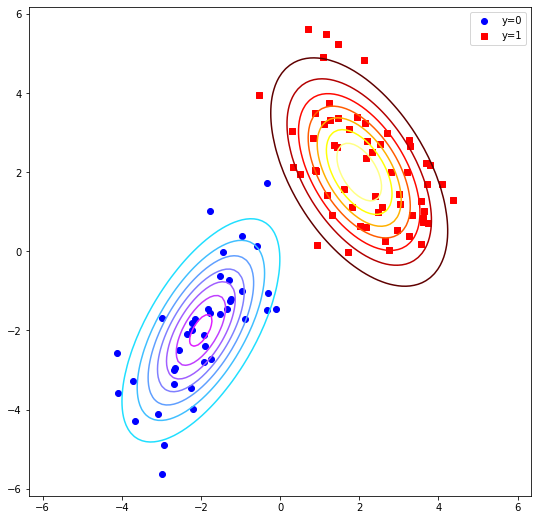

In [ ]:
np.random.seed(0)
# 다변량 가우시안 정규분포
rv0 = sp.stats.multivariate_normal([-2, -2], [[1, 0.9], [0.9, 2]])
rv1 = sp.stats.multivariate_normal([2, 2], [[1.2, -0.8], [-0.8, 2]])
X0 = rv0.rvs(40)
X1 = rv1.rvs(60)

xx1 = np.linspace(-5, 5, 100)
xx2 = np.linspace(-5, 5, 100)
XX1, XX2 = np.meshgrid(xx1, xx2)

fig = plt.figure(figsize=(9,9))
plt.grid(False)
# y=0 cycle
plt.contour(XX1, XX2, rv0.pdf(np.dstack([XX1, XX2])), cmap=mpl.cm.cool)
# y=1 cycle
plt.contour(XX1, XX2, rv1.pdf(np.dstack([XX1, XX2])), cmap=mpl.cm.hot)
plt.scatter(X0[:, 0], X0[:, 1], marker="o", c='b', label="y=0")
plt.scatter(X1[:, 0], X1[:, 1], marker="s", c='r', label="y=1")

plt.legend()
plt.axis("equal")
plt.show()

In [ ]:
from sklearn.naive_bayes import GaussianNB
model_norm = GaussianNB().fit(X, y)

y 클래스의 종류와 각 클래스에 속하는 표본의 수, 그리고 그 값으로부터 구한 사전 확률
p(y=0),p(y=1)
의 값은 다음과 같다

In [ ]:
# classes_  : 종속변수 Y의 클래스(라벨)
model_norm.classes_

array([0., 1.])

In [ ]:
# class_count_  : 종속변수 Y의 값이 특정한 클래스인 표본 데이터의 수
model_norm.class_count_

array([40., 60.])

In [ ]:
# class_prior_  : 종속변수 Y의 무조건부 확률분포 P(Y) (정규분포의 경우에만)
model_norm.class_prior_

array([0.4, 0.6])

각 클래스에 따라 x가 이루는 확률분포의 모수를 계산하면 다음과 같다. 나이브 가정에 따라 x1,x2는 독립이므로 상관관계를 구하지 않았다.

In [ ]:
# theta_: 정규분포의 기댓값 μ
# sigma_: 정규분포의 분산 sigma^2
model_norm.theta_[0], model_norm.sigma_[0]

(array([-1.96197643, -2.00597903]), array([1.02398854, 2.31390497]))

In [ ]:
model_norm.theta_[1], model_norm.sigma_[1]

(array([2.19130701, 2.12626716]), array([1.25429371, 1.93742544]))

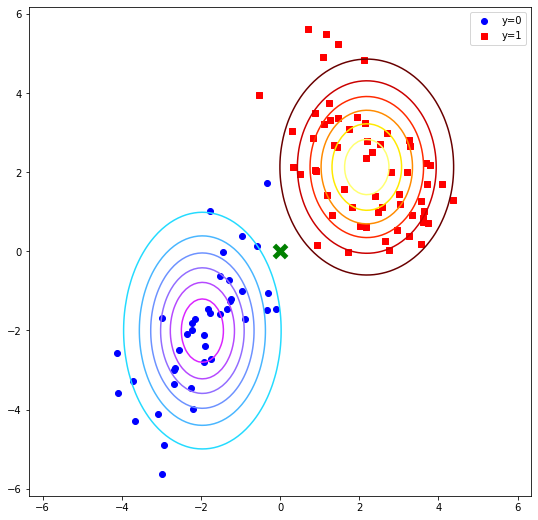

In [ ]:
rv0 = sp.stats.multivariate_normal(model_norm.theta_[0], model_norm.sigma_[0])
rv1 = sp.stats.multivariate_normal(model_norm.theta_[1], model_norm.sigma_[1])

xx1 = np.linspace(-5, 5, 100)
xx2 = np.linspace(-5, 5, 100)
XX1, XX2 = np.meshgrid(xx1, xx2)

plt.figure(figsize=(9,9))
plt.grid(False)
plt.contour(XX1, XX2, rv0.pdf(np.dstack([XX1, XX2])), cmap=mpl.cm.cool)
plt.contour(XX1, XX2, rv1.pdf(np.dstack([XX1, XX2])), cmap=mpl.cm.hot)
plt.scatter(X0[:, 0], X0[:, 1], marker="o", c='b', label="y=0")
plt.scatter(X1[:, 0], X1[:, 1], marker="s", c='r', label="y=1")

x_new = [0, 0]
plt.scatter(x_new[0], x_new[1], c="g", marker="x", s=150, linewidth=5)
plt.legend()
plt.axis("equal")
plt.show()

이 모형을 사용하여 x_new=(0,0)인 데이터의 y값을 예측하자. 각 클래스값이 나올 확률은 predict_proba 메서드로 구할 수 있다. 결과는 y=0일 확률이 0.48, y=1일 확률이 0.52이다.

In [ ]:
model_norm.predict_proba([x_new])

array([[0.48475244, 0.51524756]])

이 값이 나오게 된 중간 과정을 살펴보자. 우선 추정된 독립변수의 모수와 정규 분포의 확률 밀도 함수를 사용하여 가능도를 구할 수 있다. 나이브베이즈 가정에 따라 두 입력 변수의 곱을 결합 확률로 계산한다.

$ p(x_1,x_2|y)∝p(x_1)p(x_2) $

In [ ]:
likelihood = [
    (sp.stats.norm(model_norm.theta_[0][0], np.sqrt(model_norm.sigma_[0][0])).pdf(x_new[0]) * 
     sp.stats.norm(model_norm.theta_[0][1], np.sqrt(model_norm.sigma_[0][1])).pdf(x_new[1])),
    (sp.stats.norm(model_norm.theta_[1][0], np.sqrt(model_norm.sigma_[1][0])).pdf(x_new[0]) * 
     sp.stats.norm(model_norm.theta_[1][1], np.sqrt(model_norm.sigma_[1][1])).pdf(x_new[1])),
]
likelihood

[0.006615760017637307, 0.004687965595148289]

여기에 사전 확률을 곱하면 사후 확률에 비례하는 값이 나온다.

$ p(y|x_1,x_2)∝p(x_1,x_2|y)p(y) $

아직 정규화 상수 p(x)로 나누어주지 않았으므로 두 값의 합이 1이 아니다. 즉, 확률이라고 부를 수는 없다. 하지만 크기를 비교하면 y=0일 확률이 y=1일 확률보다 훨씬 크다는 것을 알 수 있다.

In [ ]:
posterior = likelihood * model_norm.class_prior_
print(posterior)

[0.0026463  0.00281278]


이 값을 정규화하면 predict_proba 메서드로 구한 것과 같은 값이 나온다.

In [ ]:
posterior / posterior.sum()

array([0.48475244, 0.51524756])

# Spam filter

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import urllib.request
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences 

from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import SelectPercentile

In [ ]:
filename = '/content/drive/MyDrive/Colab Notebooks/spam.csv'

In [ ]:
sms_spam= pd.read_csv(filename, encoding='latin1')
sms_spam['v2']

0       Go until jurong point, crazy.. Available only ...
1                           Ok lar... Joking wif u oni...
2       Free entry in 2 a wkly comp to win FA Cup fina...
3       U dun say so early hor... U c already then say...
4       Nah I don't think he goes to usf, he lives aro...
                              ...                        
5567    This is the 2nd time we have tried 2 contact u...
5568                Will Ì_ b going to esplanade fr home?
5569    Pity, * was in mood for that. So...any other s...
5570    The guy did some bitching but I acted like i'd...
5571                           Rofl. Its true to its name
Name: v2, Length: 5572, dtype: object

In [ ]:
# Unnamed 2,3,4 delete
del sms_spam['Unnamed: 2']
del sms_spam['Unnamed: 3']
del sms_spam['Unnamed: 4']

sms_spam.columns = ['Label','SMS']


In [ ]:
SMS_set = sms_spam['SMS'].str.replace('\W', ' ') # Removes punctuation
SMS_set = SMS_set.str.lower() # 소문자로 변환
spam_set = pd.concat([sms_spam['Label'], SMS_set], axis=1)

In [ ]:
X = spam_set['SMS']
y = spam_set['Label']

X3 = X[:3]
y3 = y[:3]

In [ ]:
X3

0    go until jurong point  crazy   available only ...
1                        ok lar    joking wif u oni   
2    free entry in 2 a wkly comp to win fa cup fina...
Name: SMS, dtype: object

In [ ]:
y3

0     ham
1     ham
2    spam
Name: Label, dtype: object

## Sckit-learn vector

참고자료: 머신러닝교과서 with 파이썬, 사이킷런, 텐서플로
1. BOW(Bag Of Word)
- 전체 문서에 대해 고유한 토큰, 예를 들어 단어로 이루어진 어휘사전을 만듦
- 특정 문서에 각 단어가 얼마나 자주 등장하는지 헤아려 문서의 특성 벡터를 만듦
2. CountVectorizer: 문서 집합(문서 리스트)에서 단어 토큰을 생성하고 각 단어의 수를 세어 BOW 기반으로 벡터를 만든다.(각 문서에서 토큰의 출현 빈도 카운트 및 BOW 인코딩 벡터로 변환)

- 문서 d에 등장한 단어 t의 횟수를 tf(t,d)처럼 같이 쓴다.
3. TfidVectorizer: TF-IDF 방식으로 단어의 가중치를 조정한 BOW 벡터를 만든다. TFIDF를 이용하면 많은 문서에 등장하는 단어는 비중이 작아지고, 특정 문서군에서만 등장하는 단어는 비중이 높아진다.

#### countVectorizer example

In [ ]:
vectorizer = CountVectorizer()
docs = np.array(['The sun is shining','The weather is sweet','The sun is shining, the weather is sweet, and one and one is two'])
bags = vectorizer.fit_transform(docs)
print(vectorizer.vocabulary_)
print(bags.toarray())

{'the': 6, 'sun': 4, 'is': 1, 'shining': 3, 'weather': 8, 'sweet': 5, 'and': 0, 'one': 2, 'two': 7}
[[0 1 0 1 1 0 1 0 0]
 [0 1 0 0 0 1 1 0 1]
 [2 3 2 1 1 1 2 1 1]]


n-gram: NLP에서 연속된 아이템(단어, 문자, 기호)의 시퀀스
기본 1-그램으로 구성되어 있음

1-gram: 'the', 'sun', 'is', 'shining'

2-gram: 'the sun', 'sun is', 'is shining'

In [ ]:
vectorizer = CountVectorizer(ngram_range=(2,2))
docs = np.array(['The sun is shining','The weather is sweet','The sun is shining, the weather is sweet, and one and one is two'])
bags = vectorizer.fit_transform(docs)
print(vectorizer.vocabulary_)
print(bags.toarray())

{'the sun': 9, 'sun is': 7, 'is shining': 1, 'the weather': 10, 'weather is': 11, 'is sweet': 2, 'shining the': 6, 'sweet and': 8, 'and one': 0, 'one and': 4, 'one is': 5, 'is two': 3}
[[0 1 0 0 0 0 0 1 0 1 0 0]
 [0 0 1 0 0 0 0 0 0 0 1 1]
 [2 1 1 1 1 1 1 1 1 1 1 1]]


#### tf-idf(term frequency-inverse document frequency)

일반적으로 자주 등장하는 단어는 판별에 필요한 정보를 가지고 있지 않는다. tf-idf는 특성 벡터에서 자주 등장하는 단어의 가중치를 낮추는 기법으로 단어 빈도와 역문서 빈도의 곱으로 정의된다.

tf-idf(t,d) = tf(t,d)*idf(t,d)

- 역문서 빈도

  idf(t,d) = log $\frac {n_d} {1+df(d,t)}$
  - $n_d$: 전체 문서 개수
  - df(d,t): 단어t가 포함된 문서 d의 개수
  - 분모 상수 1: 훈련 샘플에 한 번도 등장하지 않는 단어가 있는 경우 분모가 0이 되지 않게 만듦
  - log: 문서빈도 df(d,t)가 낮을 때 역문서 빈도 값이 너무 커지지 않도록 만듦

In [ ]:
vectorizer = TfidfVectorizer()
Tfid = vectorizer.fit_transform(docs)
#소수점 둘째자리까지 표시
np.set_printoptions(precision=2)
print(vectorizer.vocabulary_)
print(Tfid.toarray())

{'the': 6, 'sun': 4, 'is': 1, 'shining': 3, 'weather': 8, 'sweet': 5, 'and': 0, 'one': 2, 'two': 7}
[[0.   0.43 0.   0.56 0.56 0.   0.43 0.   0.  ]
 [0.   0.43 0.   0.   0.   0.56 0.43 0.   0.56]
 [0.5  0.45 0.5  0.19 0.19 0.19 0.3  0.25 0.19]]


'and': 0,  'is': 1,  'one': 2,  'shining': 3,  'sun': 4,  'sweet': 5,  'the': 6,  'two': 7,  'weather': 8}

- count vector

[0 1 0 1 1 0 1 0 0]

 [0 1 0 0 0 1 1 0 1]

 [2 3 2 1 1 1 2 1 1]

 - tf-idf

[0.   0.43 0.   0.56 0.56 0.   0.43 0.   0.  ]

 [0.   0.43 0.   0.   0.   0.56 0.43 0.   0.56]

 [0.5  0.45 0.5  0.19 0.19 0.19 0.3  0.25 0.19]

**사이킷런** 

- 역빈도 공식

  idf(t,d) = log $\frac {1+n_d} {1+df(d,t)}$

- tf-idf공식

  tf-idf(t,d) = tf(t,d)*(idf(t,d)+1)

- 정규화 L2

  TfidfVectorizer는 기본적으로 L2정규화를 적용함

- 예제: 세번째 문서 'is'
  - 단어 빈도 3 (tf=3)
  - 세개의 문서에 모두 나타나기 때문에 문서 빈도 3 (df=3)
  - 역문서 빈도: idf('is', d3) = log$\frac {1+3} {1+3}$ = 0
  - tf-idf('is',d3) = 3*(0+1) = 3

- 세번째 문서에 있는 모든 단어를 위와 같이 계산해보면 다음과 같음

  tf-idf = [3.39, 3.0, 3.39, 1.29, 1.29, 1.29, 2.0, 1.69, 1.29]

- L2-정규화 과정 적용

  $tf-idf(d3)_{norm} = \frac {[3.39, 3.0, 3.39, 1.29, 1.29, 1.29, 2.0, 1.69, 1.29]} {\sqrt {3.39^2+3.0^2+ 3.39^2+ 1.29^2+ 1.29^2+ 1.29^2+ 2.0^2+ 1.69^2+ 1.29^2}}$ 
  
  = [0.5 0.45 0.5 0.19 0.19 0.19 0.3 0.25 0.19]

  따라서, tf-idf('is'.d3) = 0.45가 됨


**정규화 L1, L2**

ridge&lasso: https://mole-starseeker.tistory.com/34

#### CountVectorizer

In [ ]:
vectorizer = CountVectorizer()
count_X = vectorizer.fit_transform(X3)
print(vectorizer.vocabulary_)
print(count_X.toarray())

{'go': 17, 'until': 39, 'jurong': 22, 'point': 29, 'crazy': 11, 'available': 6, 'only': 28, 'in': 20, 'bugis': 8, 'great': 19, 'world': 44, 'la': 23, 'buffet': 7, 'cine': 9, 'there': 35, 'got': 18, 'amore': 4, 'wat': 40, 'ok': 26, 'lar': 24, 'joking': 21, 'wif': 41, 'oni': 27, 'free': 16, 'entry': 13, 'wkly': 43, 'comp': 10, 'to': 37, 'win': 42, 'fa': 14, 'cup': 12, 'final': 15, 'tkts': 36, '21st': 2, 'may': 25, '2005': 1, 'text': 34, '87121': 3, 'receive': 32, 'question': 30, 'std': 33, 'txt': 38, 'rate': 31, 'apply': 5, '08452810075over18': 0}
[[0 0 0 0 1 0 1 1 1 1 0 1 0 0 0 0 0 1 1 1 1 0 1 1 0 0 0 0 1 1 0 0 0 0 0 1
  0 0 0 1 1 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0
  0 0 0 0 0 1 0 0 0]
 [1 1 1 1 0 1 0 0 0 0 1 0 1 2 2 1 1 0 0 0 1 0 0 0 0 1 0 0 0 0 1 1 1 1 1 0
  1 3 1 0 0 0 1 1 0]]


In [ ]:
count_nb = GaussianNB()

count_nb.fit(count_X,y3)

GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
count_nb.class_prior_

array([0.66666667, 0.33333333])

#### TfidVectorizer

In [ ]:
vectorizer = TfidfVectorizer()
Tfid_X = vectorizer.fit_transform(X3).toarray()
print(Tfid_X)

[[0.         0.         0.         0.         0.23851206 0.
  0.23851206 0.23851206 0.23851206 0.23851206 0.         0.23851206
  0.         0.         0.         0.         0.         0.23851206
  0.23851206 0.23851206 0.18139457 0.         0.23851206 0.23851206
  0.         0.         0.         0.         0.23851206 0.23851206
  0.         0.         0.         0.         0.         0.23851206
  0.         0.         0.         0.23851206 0.23851206 0.
  0.         0.         0.23851206]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.4472136  0.         0.
  0.4472136  0.         0.4472136  0.4472136  0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.4472136
  0.         0.         0.        ]
 [0.1653437  0.1653437  0.1653437  0.1653

In [ ]:
Tfid_nb = GaussianNB()

Tfid_nb.fit(Tfid_X,y3)

GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
Tfid_nb.class_prior_

array([0.66666667, 0.33333333])

#### TfidVectorizer + SelectPercentile
- 너무 많은 feature는 오버피팅의 원인이 됨으로 필요한 feature를 선택
- 최적의 feature를 선택하기 위해 Chi square, F-test, ANOVA 등의 통계 모델을 사용

In [ ]:
vectorizer = TfidfVectorizer()

In [ ]:
X_transformed = vectorizer.fit_transform(X3)

scikit-learn에서 univariate로 특성을 선택하려면 

1. 분류에는 f_classif(default)를, 회귀에서는 f_regression을  선택하여 테스트

2. 계산한 p-value에 기초하여 특성을 제외하는 방식을 선택. 



이런 방식들은 매우 높은 p-value를 가진(target값과 연관성이 적은) 특성을 제외할 수 있도록 critical value를 조정하는 parameter를 사용

critical value를 계산하는 방법중 하나인 SelectKBest는 고정된 k개의 특성을 선택하고 SelectPercentile은 지정된 비율만큼 특성을 선택

In [ ]:
selector = SelectPercentile(percentile=5)
selector

SelectPercentile(percentile=5,
                 score_func=<function f_classif at 0x7f7b435b0c80>)

In [ ]:
selector.fit(X_transformed,y3)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


SelectPercentile(percentile=5,
                 score_func=<function f_classif at 0x7f7b435b0c80>)

In [ ]:
data_transformed = selector.transform(X_transformed).toarray()
data_transformed

array([[0.       , 0.       ],
       [0.       , 0.       ],
       [0.1653437, 0.1653437]])

In [ ]:
m1 = GaussianNB()

m1.fit(data_transformed,y3)

GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
m1.classes_

array(['ham', 'spam'], dtype='<U4')

In [ ]:
m1.class_count_

array([2., 1.])

In [ ]:
m1.class_prior_

array([0.66666667, 0.33333333])

In [ ]:
m1.theta_[0], m1.sigma_[0]

(array([0., 0.]), array([6.07523089e-12, 6.07523089e-12]))

In [ ]:
m1.theta_[1], m1.sigma_[1]

(array([0.1653437, 0.1653437]), array([6.07523089e-12, 6.07523089e-12]))

# CNN

cnn 이해: https://bcho.tistory.com/tag/%EB%A7%A5%EC%8A%A4%ED%92%80%EB%A7%81

text cnn 논문: http://docs.likejazz.com/cnn-text-classification-tf/

cnn 역전파: https://ratsgo.github.io/deep%20learning/2017/04/05/CNNbackprop/